# Content and Objectives

- Show realization of COST 207 channels
+ According to: P.  Jung:  Analyse  und  Entwurf  digitaler  Mobilfunksysteme.  Stuttgart:  B.G.  Teubner  Verlag,  1997

# Import

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 10) )

# Helper Functions

In [3]:
########################
# get delays for the taps
########################
def get_delay_pdp(scenario, delay_max=20e-6, delay_numb_points=100, numb_samples=1):
    """
    Provides a sample delay of the power delay profile according to the channel type
    
    Note: 
        output delay (in seconds)
        realizes profile of COST 207
    
    IN: 
        channel type out of 'RA', 'TU', 'BU', 'HT'
        delay_max: maximum  delay of the pdp
        delay_numb_points: number of points in (0, delay_max)
        numb_samples: number of delays to be generated        
        
    OUT: delay value according to the pdp
    
    """

    # check if feasible channel type is been used
    feasible_channels = ['RA', 'TU', 'BU', 'HT']
    assert( scenario in feasible_channels), 'Scenario has to be out of'+str(feasible_channels)
    
    
    # generate vector of delay  
    delay_step = delay_max/delay_numb_points  
    tau = np.arange(0, delay_max, delay_step)

    # choose channel type and determine cdf
    if scenario=='RA':
        # rural profile
        pdp = np.exp(-9.2*tau)
        pdp[ np.where(tau>0.7e-6+delay_step/2) ] = 0

        cdf = np.cumsum(pdp)
        
    elif scenario=='TU':
        
        # typical urban
        pdp = np.exp(-tau)
        pdp[ np.where(tau>7e-6) ] = 0

        cdf = np.cumsum(pdp)
        
    elif scenario=='BU':
    
        # bad urban
        pdp = np.exp(-tau)
        pdp[ np.where(tau>5e-6) ] = 0    
        pdp[ np.where( abs(tau-7.5e-6)<2.5e-6) ] += .5*np.exp(5e-6-tau[np.where( abs(tau-7.5e-6)<2.5e-6) ])
    
        cdf = np.cumsum(pdp)
        
    elif scenario=='HT':
        
        # hilly terrain
        pdp = np.exp(-3.5*tau)
        pdp[ np.where(tau>2e-6) ] = 0    
        pdp[ np.where( np.abs(tau-17.5e-6)<2.5e-6) ] += .1*np.exp(15e-6-tau[np.where( abs(tau-17.5e-6)<2.5e-6) ])    
    
    cdf = np.cumsum(pdp) / np.sum(pdp)

    # sample uniform distribution
    u_vector = np.random.uniform(size=numb_samples)
    
    delay = [ min( tau[ np.where( cdf>u) ] ) for u in u_vector]
    
    return np.sort(delay)

In [4]:
########################
# get delays for the taps
########################
def get_freqs_dpp(delays, scenario, nu_max, nu_numb_points=50):
    """
    Provides a sample Doppler shift according to the Doppler class being determined by the delays
    
    Note: realizes profile of COST 207
    
    IN: 
        delays as generated by the pdp
        channel_type for using RICE in urban scenarios
        nu_max: maximum  Doppler freq
        nu_numb_points: number of points (resolution) in (-nu_max, nu_max)

        
    OUT: Doppler shift according to the chosen pdp
    
    """

    # generate vector of dopplers  
    nu_step = 2*nu_max/nu_numb_points  
    nu = np.arange(-nu_max+nu_step, nu_max, nu_step)
    
    # determine cdfs in order to generate the according RV
    # CLASS
    jakes = 1/np.sqrt(1-(nu/nu_max)**2)
    cdf_jakes = np.cumsum(jakes)/np.sum(jakes)
    
    # GAUS1
    gaus1 = np.exp(-(nu+.8*nu_max)**2 / (2* (.05*nu_max)**2)) + .1 * np.exp( -(nu-.4*nu_max)**2/(2*(.1*nu_max)**2))
    cdf_gaus1 = np.cumsum(gaus1)/np.sum(gaus1)

    # GAUS2
    gaus2 = np.exp(-(nu-.7*nu_max)**2 / (2* (.1*nu_max)**2)) + .1 * np.exp( -(nu+.4*nu_max)**2/(2*(.15*nu_max)**2))
    cdf_gaus2 = np.cumsum(gaus2)/np.sum(gaus2)    

    # RICE
    rice = .41/(2*np.pi*nu_max*np.sqrt(1-(nu/nu_max)**2)) 
    cdf_rice = np.cumsum(rice)/np.sum(rice)


    # determine Doppler shifts
    doppler = np.zeros( len(delays) )
    
    for de in delays:
        
        if (scenario=='TU' or scenario=='BU') and de==min(delays):
            cdf = cdf_rice
            
        elif de <= 0.5e-6:
            cdf = cdf_jakes
            
        elif (.5e-6) < de and (de <= 2e-6):
            cdf = cdf_gaus1
            
        elif de > 2e-6:
            cdf = cdf_gaus2
          

        u = np.random.uniform()
        doppler[ np.where(delays==de) ] = np.min( nu[np.where( cdf>u)] )

    return doppler

# Parameters

In [5]:
# sample time and frequency 
# former in \mu s, latter in MHz

# note that -- since f is in MHz and delays is in microseconds -- the correspondings 1e6 cancel each other    

t_max = 50
t_step = .1
t_unit = 1e-3
t = np.arange(0, t_max, t_step) 

f_max = 2
f_step = .025
f_unit = 1e6
f = np.arange(-f_max, f_max+f_step, f_step) 

In [6]:
# parameters for simulation impulse response and frequency response

# number of random summands
E = int(5e2)
    
# parameters of mobile station's dynamics
f_Doppler = 100   

# determine parameters in order to get an realization of a COST channel
# defining scenario type out or 'RA', 'TU', 'BU', 'HT'
scenario = 'HT'

phases = 1/(2*np.pi)*np.random.uniform(0, 1, E)

delays = get_delay_pdp(scenario, 20e-6, 1e2, E)

doppler = get_freqs_dpp(delays, scenario, f_Doppler, 1e2)       

# Get Channel

In [7]:
# determine time-freq response according to [Jung: Analyse und Entwurf digitaler Mobilfunksysteme]
H = np.zeros( (np.size(t), np.size(f)), dtype=complex)

for e in np.arange(E):
    H += 1/np.sqrt(E)*np.exp(1j*phases[e])*np.outer(np.exp(1j*2*np.pi*doppler[e]*t*t_unit), np.exp(-1j*2*np.pi*f*f_unit*delays[e]) )


# determine impulse response by inverse FFT w.r.t. f
tau = np.linspace(0, 1/f_step, len(f))
h = np.zeros( (np.size(t), np.size(tau)), dtype=complex )    

for time in t:
    h[ np.where(t==time), :] = np.fft.ifft( np.fft.fftshift(H[ np.where(t==time), :]))

# values for plotting
H /= H.max()
H_db = 20*np.log10( abs(H) )

F, T = np.meshgrid(f, t)
TAU, T = np.meshgrid(tau, t)

# Pulse Shape and Effect of Multi-Path on Pulse Shape

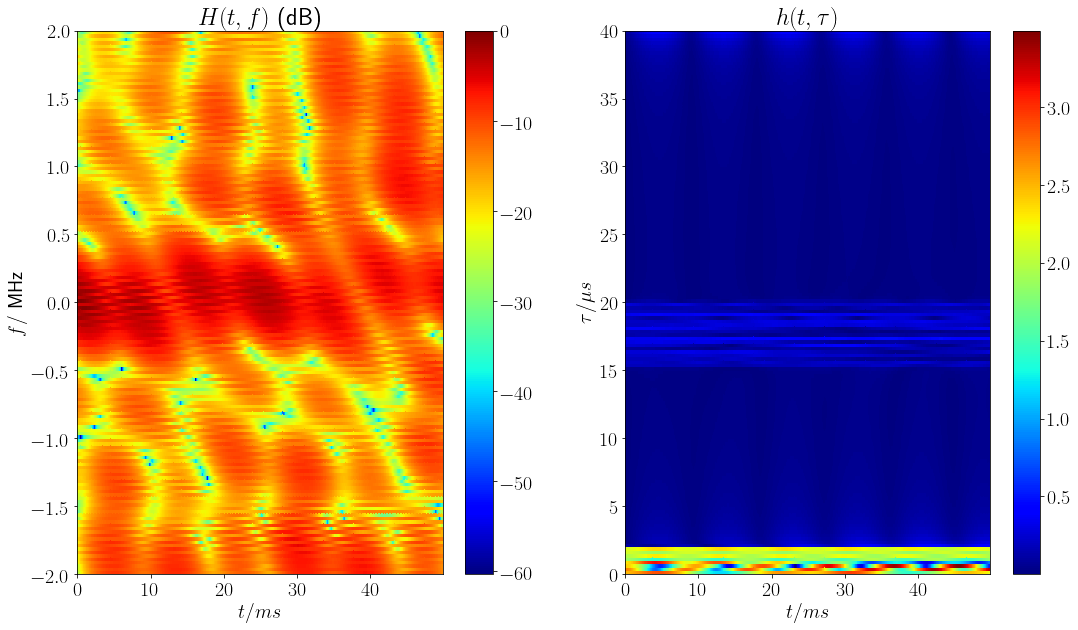

In [8]:
# plot as colormap
Fig = plt.figure()
plt.subplot(121)
ax = Fig.gca()
color_H = ax.pcolormesh(T, F, H_db, cmap='jet')    
plt.xlabel('$t/ms$')
plt.ylabel('$f/$ MHz')   
plt.title('$H(t, f)$ (dB)')
Fig.colorbar(color_H, orientation='vertical')

# plot as colormap
#Fig = figure()
plt.subplot(122)        
ax = Fig.gca()
color_h = ax.pcolormesh(T, TAU, abs(h), cmap='jet')    
plt.xlabel('$t/ms$')
plt.ylabel('$\\tau/\\mu s$')  
plt.title('$h(t, \\tau)$')
Fig.colorbar(color_h, orientation='vertical')  